In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.sparse import dia_matrix
import pandas as pd
from qutip import *
import os
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

np.set_printoptions(suppress=True)

def set_nature_style():
    mpl.rcParams.update({
        # Typography
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
        "mathtext.fontset": "stixsans",
        "font.size": 8,

        # Lines/markers
        "lines.linewidth": 1.0,
        "lines.markersize": 3,
        "axes.linewidth": 0.8,

        # Ticks
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.major.size": 3.5,
        "ytick.major.size": 3.5,
        "xtick.minor.size": 2.0,
        "ytick.minor.size": 2.0,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.minor.width": 0.6,
        "ytick.minor.width": 0.6,
        "xtick.top": True,
        "ytick.right": True,

        # Layout / export
        "figure.dpi": 150,
        "savefig.dpi": 600,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.02,
    })

set_nature_style()


![My plot](notebook_figs/crystal_orientation.png)

In [5]:
from qutip import spin_J_set, expect, tensor, qeye, Qobj
from scipy.constants import h, c, e, m_e, m_n, alpha, mu_0, hbar

# Physical constants
h    = 6.6260693e-34       # Plank constant
mu_0 = 12.566370614e-7     # Vacuum permeability
mu_B = 9.27401007831e-24   # Bohr magneton in J/T
mu_N = 5.0507836991e-27    # Nuclear magneton in J/T

# Er3+ gyromagnetic ratio
gamma_Er = np.array([117.3, 117.3, 17.45]) * 1e9 * h  # hyperfine coupling constants in Hz/T * h
g_Er = gamma_Er / mu_B
g_a, g_b, g_c = g_Er

# Tungsten-183 nuclear magnetic moment
gamma_W_ref = 1.77394e6 # MHz/T
mu_W = gamma_W_ref * h  # J/T
g_W = mu_W / mu_N

# Niobium-93 nuclear magnetic moment
gamma_Nb_ref = 6.567400e7/2/np.pi # MHz/T
mu_Nb = gamma_Nb_ref * h  # J/T
g_Nb = mu_Nb / mu_N

# Calcium-43 nuclear magnetic moment
gamma_Ca_ref = -2.86899e6          # Hz/T  (=-2.86899 MHz/T)  (43Ca)  :contentReference[oaicite:3]{index=3}
mu_Ca = gamma_Ca_ref * h           # J/T
g_Ca  = mu_Ca / mu_N   

In [6]:
# 832 closest tungsten positions with respect to Er3+
W_pos = np.loadtxt('positions_ErW_CaWO4.txt') * 1e-10 # Tungsten atom positions in Amstrongs
n_W_pos = len(W_pos)

# reconstructed tungsten positions from measurement
W_pos_meas = np.array([
     [0,0.0000e+00, 2.6215e-10, 8.5320e-10],
     [0,7.8645e-10, 2.6215e-10, 1.1376e-09],
     [0,-2.6215e-10,  5.2430e-10, 2.8440e-10],
     [0,-2.6215e-10 , 2.6215e-10, 1.1376e-09],
     [0,-2.6215e-10 , 0.0000e+00, 2.8440e-10],
     [0,1.0486e-09, 2.6215e-10, 8.5320e-10],
     [0,7.8645e-10, 7.8645e-10, 0.0000e+00],
     [0,2.6215e-10, 5.2430e-10 ,1.4220e-09],
     [0,2.6215e-10 ,2.6215e-10 ,1.1376e-09],
     ]) - np.array([0,2.6215e-10 ,2.6215e-10 ,1.1376e-09/2]) # center at Er3+
W_pos_meas *= -1

In [43]:
raw_data = np.loadtxt('mp-19426_CaWO4.xyz', dtype = str) # Tungsten atom positions in Amstrongs
elements = raw_data[:, 0]                     # strings, shape (N,)
pos = raw_data[:, 1:].astype(float)           # floats, shape (N,3)
Crystal_atoms = np.empty(len(elements), dtype=[("el", "U8"), ("xyz", float, (3,))])
Crystal_atoms["el"] = elements
Crystal_atoms["xyz"] = pos

import numpy as np
import matplotlib.pyplot as plt

def wrap_to_centered_cell(r, L):
    r = np.asarray(r, float)
    L = np.asarray(L, float)
    return (r + 0.5 * L) % L - 0.5 * L

def replicate_images(atoms, L, reps=(-1, 0, 1)):
    L = np.asarray(L, float)
    shifts = np.array([[i, j, k] for i in reps for j in reps for k in reps], float)
    out = []
    for s in shifts:
        shifted = np.empty(len(atoms), dtype=atoms.dtype)
        shifted["el"] = atoms["el"]
        shifted["xyz"] = atoms["xyz"] + s * L
        out.append(shifted)
    return np.concatenate(out)

def keep_near_cell(atoms, L, margin=1e-6):
    L = np.asarray(L, float)
    xyz = atoms["xyz"]
    lo = -0.5 * L - margin
    hi =  0.5 * L + margin
    m = np.all((xyz >= lo) & (xyz <= hi), axis=1)
    return atoms[m]

def plot_unit_cell(
    Crystal_atoms,
    L=np.array([5.334534, 5.334534, 11.50991]),
    atoms_to_plot=None,
    show_only=("Ca", "W", "Center_C"),
    ball_size=360,
    elev=18,
    azim=35,
    draw_cell=True,
    highlight_center=True,
    center_label="Center_C",
    center_size=1400,
    depth_shading=True,
    depth_strength=0.35,
    cell_mode="centered",   # "centered" or "ca_corners"
):
    """
    cell_mode:
      - "centered": box is centered at (0,0,0). (Corners are W for your coordinates.)
      - "ca_corners": uses a translated equivalent cell so Ca appear at corners.
                      Center marker is placed at the geometric center of the drawn box.
    """

    if atoms_to_plot is None:
        atoms_to_plot = len(Crystal_atoms)
    atoms = Crystal_atoms[:int(atoms_to_plot)]

    if show_only is not None:
        atoms = atoms[np.isin(atoms["el"], np.array(show_only, dtype=str))]

    L = np.asarray(L, float)
    hx, hy, hz = 0.5 * L

    # ------------------------------------------------------------
    # Choose a cell translation (same lattice, different "box")
    # ------------------------------------------------------------
    # For your structure, shifting by (Lx/2, Ly/2, 0) tends to move Ca from faces/edges
    # into the "corner set" of the displayed box (equivalent choice of unit cell).
    if cell_mode == "centered":
        cell_shift = np.array([0.0, 0.0, 0.0])
    elif cell_mode == "ca_corners":
        cell_shift = np.array([hx, hy, 0.0])
    else:
        raise ValueError("cell_mode must be 'centered' or 'ca_corners'")

    # Shift atom coordinates by -cell_shift before wrapping so the drawn box is "moved"
    shifted = np.empty(len(atoms), dtype=atoms.dtype)
    shifted["el"] = atoms["el"]
    shifted["xyz"] = atoms["xyz"] - cell_shift

    # Wrap into centered cell coordinates (of the shifted box)
    wrapped = np.empty(len(shifted), dtype=shifted.dtype)
    wrapped["el"] = shifted["el"]
    wrapped["xyz"] = wrap_to_centered_cell(shifted["xyz"], L)

    # Replicate images and keep boundary atoms (corners/edges/faces visible)
    images = replicate_images(wrapped, L, reps=(-1, 0, 1))
    unitcell_atoms = keep_near_cell(images, L, margin=1e-6)

    els = unitcell_atoms["el"]
    xyz = unitcell_atoms["xyz"].astype(float)

    # -------------------------
    # Colors
    # -------------------------
    base_colors = {
        "Ca": np.array([0.121, 0.466, 0.705, 1.0]),   # tab:blue
        "W":  np.array([1.000, 0.498, 0.054, 1.0]),   # tab:orange
        center_label: np.array([0.86, 0.08, 0.24, 1.0])  # crimson-ish
    }
    colors = np.array([base_colors.get(el, np.array([0.5, 0.5, 0.5, 1.0])) for el in els], float)

    # -------------------------
    # Extra depth shading (stronger depth cue)
    # -------------------------
    if depth_shading and len(xyz) > 0:
        elr = np.deg2rad(elev)
        azr = np.deg2rad(azim)
        v = np.array([np.cos(elr)*np.cos(azr), np.cos(elr)*np.sin(azr), np.sin(elr)])
        depth = xyz @ v
        d0 = (depth - depth.min()) / (depth.max() - depth.min() + 1e-12)
        bright = (1.0 - depth_strength) + depth_strength * d0
        colors[:, :3] = colors[:, :3] * bright[:, None]

    # -------------------------
    # Plot
    # -------------------------
    fig = plt.figure(figsize=(8.5, 7))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        xyz[:, 0], xyz[:, 1], xyz[:, 2],
        s=ball_size,
        c=colors,
        depthshade=True,
        edgecolors="k",
        linewidths=0.35,
        alpha=1.0
    )

    # Draw the centered unit-cell box
    if draw_cell:
        corners = np.array([
            [-hx, -hy, -hz], [ hx, -hy, -hz], [ hx,  hy, -hz], [-hx,  hy, -hz],
            [-hx, -hy,  hz], [ hx, -hy,  hz], [ hx,  hy,  hz], [-hx,  hy,  hz],
        ], float)
        edges = [
            (0, 1), (1, 2), (2, 3), (3, 0),
            (4, 5), (5, 6), (6, 7), (7, 4),
            (0, 4), (1, 5), (2, 6), (3, 7)
        ]
        for i, j in edges:
            ax.plot(
                [corners[i, 0], corners[j, 0]],
                [corners[i, 1], corners[j, 1]],
                [corners[i, 2], corners[j, 2]],
                linewidth=1.2, color="black", alpha=0.75
            )

    # Highlight "center" marker:
    # - in centered mode: Center_C should be at (0,0,0) if present
    # - in ca_corners mode: we *force* the highlight at geometric center (0,0,0)
    if highlight_center:
        ax.scatter(
            [0.0], [0.0], [0.0],
            s=center_size,
            c=[base_colors.get(center_label, np.array([0.86, 0.08, 0.24, 1.0]))],
            marker="*",
            depthshade=False,
            edgecolors="k",
            linewidths=1.0,
            alpha=1.0,
            zorder=10
        )

    ax.set_xlabel("a (x)  [Å]")
    ax.set_ylabel("b (y)  [Å]")
    ax.set_zlabel("c (z)  [Å]")
    ax.view_init(elev=elev, azim=azim)

    # Make c visibly longer
    ax.set_xlim(-hx * 1.05, hx * 1.05)
    ax.set_ylim(-hy * 1.05, hy * 1.05)
    ax.set_zlim(-hz * 1.05, hz * 1.05)
    try:
        ax.set_box_aspect((L[0], L[1], L[2]))
    except Exception:
        pass

    # Legend
    unique_els = np.unique(els)
    handles, labels = [], []
    for el in unique_els:
        mk, ms = ("*", 12) if el == center_label else ("o", 10)
        fc = base_colors.get(el, np.array([0.5, 0.5, 0.5, 1.0]))
        handles.append(plt.Line2D([0],[0], marker=mk, linestyle="",
                                  markerfacecolor=fc[:3], markeredgecolor="k",
                                  markersize=ms))
        labels.append(el)
    # also show the forced center marker in legend
    if center_label not in unique_els:
        handles.append(plt.Line2D([0],[0], marker="*", linestyle="",
                                  markerfacecolor=base_colors[center_label][:3],
                                  markeredgecolor="k", markersize=12))
        labels.append(center_label)

    ax.legend(handles, labels, title=f"Sites (cell_mode={cell_mode})",
              loc="upper left", bbox_to_anchor=(1.02, 1.0))

    plt.tight_layout()
    plt.show()
    return fig, ax, unitcell_atoms


# =========================
# Calls
# =========================
# 1) Your original convention (Center_C is truly the cell center; corners will be W)
# plot_unit_cell(Crystal_atoms, cell_mode="centered")

# 2) Equivalent translated cell where Ca appear at the corners (and the star is forced to the box center)
# plot_unit_cell(Crystal_atoms, cell_mode="ca_corners")


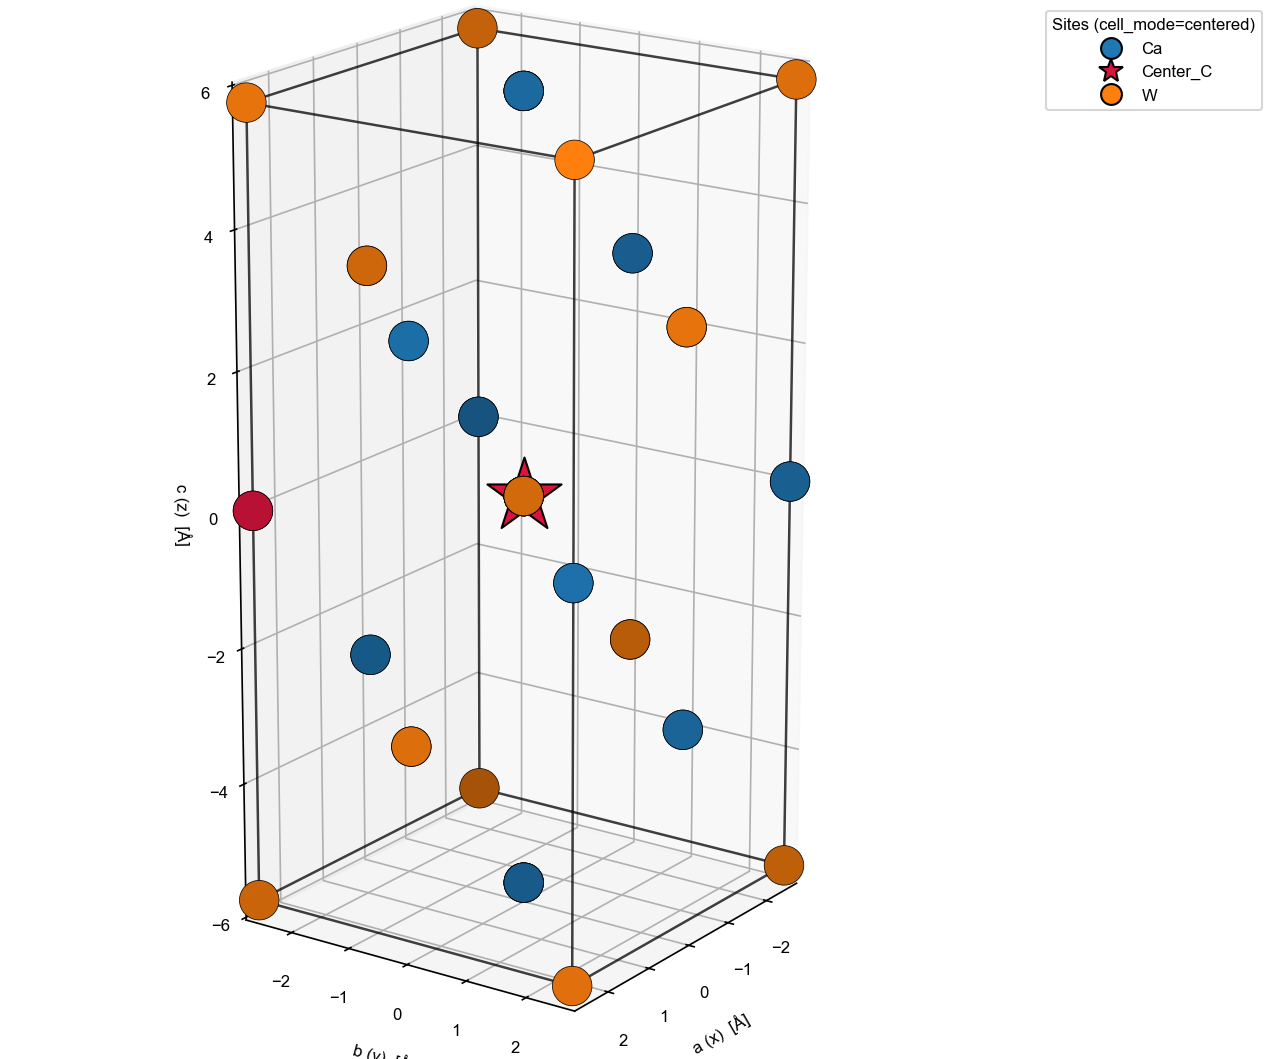

(<Figure size 1275x1050 with 1 Axes>,
 <Axes3D: xlabel='a (x)  [Å]', ylabel='b (y)  [Å]', zlabel='c (z)  [Å]'>,
 array([('Ca', [-2.667267,  0.      ,  2.877477]),
        ('Ca', [-2.667267,  0.      ,  2.877477]),
        ('Center_C', [-2.667267, -2.667267,  0.      ]),
        ('Ca', [-2.667267, -2.667267,  0.      ]),
        ('Ca', [ 0.      , -2.667267, -2.877478]),
        ('Ca', [ 0.      , -2.667267, -2.877478]),
        ('Ca', [ 0.      ,  0.      , -5.754955]),
        ('Ca', [ 0.      ,  0.      , -5.754955]),
        ('Ca', [ 0.      ,  0.      , -5.754955]),
        ('Ca', [ 0.      ,  0.      , -5.754955]),
        ('W', [ 0.      , -2.667267,  2.877477]),
        ('W', [ 0.      , -2.667267,  2.877477]),
        ('W', [ 0.      ,  0.      ,  0.      ]),
        ('W', [ 0.      ,  0.      ,  0.      ]),
        ('W', [ 0.      ,  0.      ,  0.      ]),
        ('W', [ 0.      ,  0.      ,  0.      ]),
        ('W', [ 0.      ,  0.      ,  0.      ]),
        ('W', [ 0.    

In [44]:
plot_unit_cell(Crystal_atoms, cell_mode="centered")

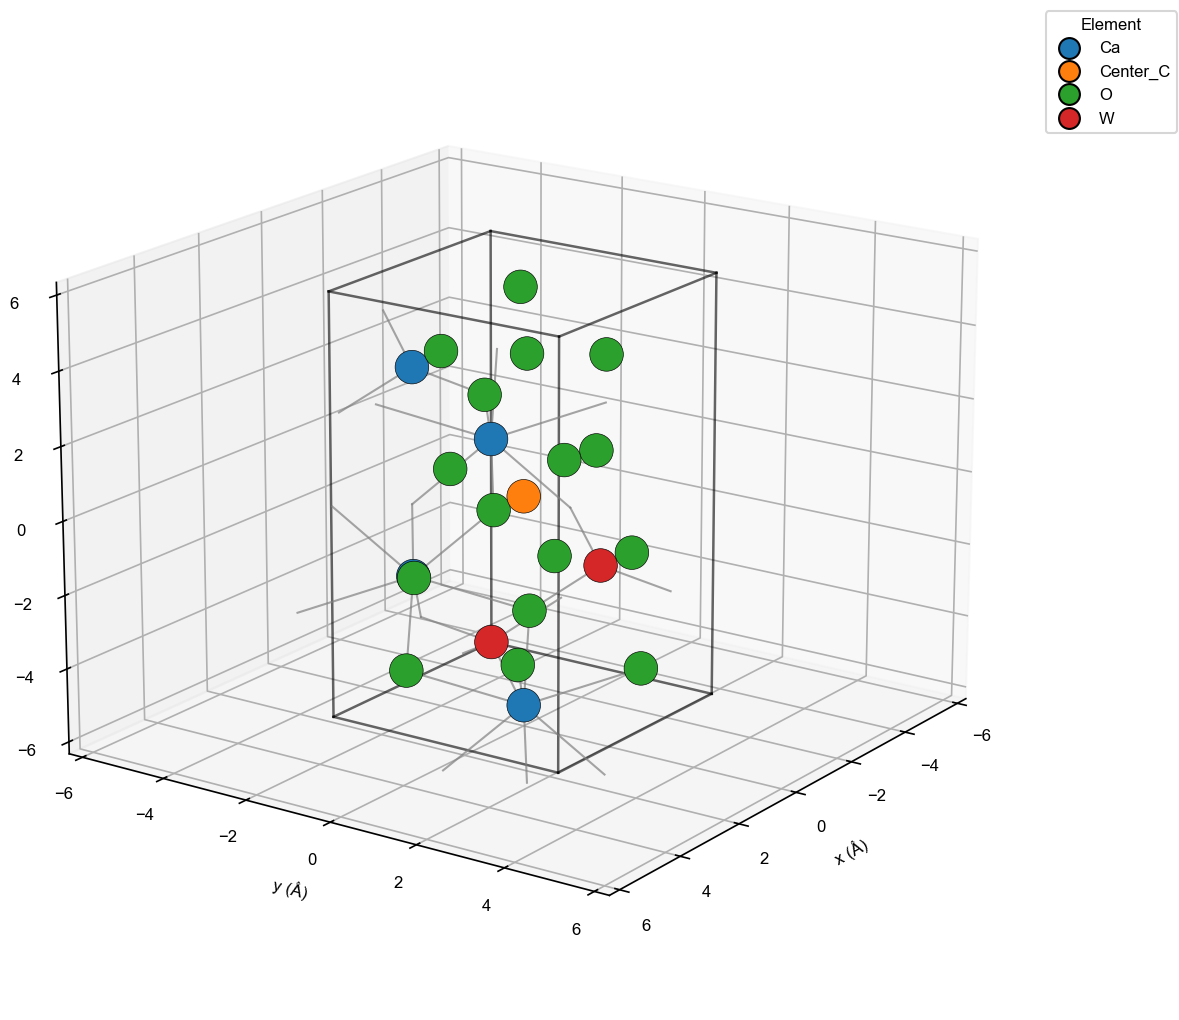

In [31]:
fig, ax, unitcell_atoms, L = plot_first_unit_cell_centered(
    Crystal_atoms,
    atoms_to_plot=len(Crystal_atoms),  # or e.g. 200
    L=np.array([5.334534, 5.334534, 11.50991]),  # optional; can omit to auto-guess
    draw_cell=True,
    draw_bonds=True
)

In [18]:
W_pos.shape

(832, 4)

In [19]:
W_pos_meas[:,1:] * 1e10  # convert back to Angstroms for visualization

array([[ 2.6215, -0.    , -2.844 ],
       [-5.243 , -0.    , -5.688 ],
       [ 5.243 , -2.6215,  2.844 ],
       [ 5.243 , -0.    , -5.688 ],
       [ 5.243 ,  2.6215,  2.844 ],
       [-7.8645, -0.    , -2.844 ],
       [-5.243 , -5.243 ,  5.688 ],
       [-0.    , -2.6215, -8.532 ],
       [-0.    , -0.    , -5.688 ]])

Here we build the Hamiltonian

In [21]:
J, I = 1/2, 1/2
nJ = int(2*J + 1)
nI = int(2*I + 1)
Jvec = Jx, Jy, Jz = spin_J_set(J)
Ivec = Ix, Iy, Iz = spin_J_set(I)


In [8]:
# utilities

def rotmat_xz(theta):
    return np.array([[np.cos(theta),  0, -np.sin(theta)],
                     [            0,  1,             0],
                     [np.sin(theta), 0, np.cos(theta)]])

def rotmat_yz(theta):
    theta = -theta
    return np.array([[1,             0,              0],
                     [0, np.cos(theta), -np.sin(theta)],
                     [0, np.sin(theta),  np.cos(theta)]])

name_factor_unit = [
    (r"$\omega_e$ (GHz)", 1e-3),
    (r"$\Delta\omega_e$ (kHz)", 1e3),
    (r"$\omega_n$ (kHz)", 1e3),
    (r"$\Delta\omega_n$ (kHz)", 1e3)
]

label_map = [
    r'$|\downarrow_e\uparrow_n\rangle$',
    r'$|\downarrow_e\downarrow_n\rangle$',
    r'$|\uparrow_e\uparrow_n\rangle$',
    r'$|\uparrow_e\downarrow_n\rangle$',
]

# 1 electron + nucleus

In [11]:
def get_electron_zeeman_hamiltonian(g_elec, B_field, Jvec) -> Qobj: # [MHz]
    _Jx, _Jy, _Jz = Jvec
    g_x, g_y, g_z = g_elec
    return mu_B * (B_field[0]*g_x*_Jx + B_field[1]*g_y*_Jy + B_field[2]*g_z*_Jz) / h * 1e-6 

def get_nuclear_zeeman_hamiltonian(mu_I, B_field, Ivec) -> Qobj: # [MHz]
    _Ix, _Iy, _Iz = Ivec
    return - mu_I * (B_field[0]*_Ix + B_field[1]*_Iy + B_field[2]*_Iz) / h * 1e-6

# for 1-electron spin + 1-nuclear spin system
def get_electron_nuclear_zeeman_hamiltonian(g_elec, mu_I, B_field, Jvec, Ivec) -> Qobj: # [MHz]
    nJ, nI  = Jvec[0].dims[0][0], Ivec[0].dims[0][0]
    h_zeeman_electron = tensor(get_electron_zeeman_hamiltonian(g_elec, B_field, Jvec), qeye(nI))
    h_zeeman_nuclear  = tensor(qeye(nJ),  get_nuclear_zeeman_hamiltonian(mu_I, B_field, Ivec)) 
    return h_zeeman_electron + h_zeeman_nuclear

def get_hyperfine_tensor(g_electron, mu_I, xyz):
    """
    Calculates the hyperfine tensor and hamiltonian due to the dipole-dipole interaction between two spins
    The expression for the hyperfine tensor used is detailed in Le Dantec's Thesis (2022), p36
  
    """
    g_a, g_b, g_c = g_electron
    x, y, z = xyz
    r = np.linalg.norm(xyz)
    
    Tdd = np.zeros((3, 3)) # dipole-dipole tensor
    prefactor = r**-5 * mu_B * mu_I * mu_0/(4*np.pi)

    # diagonal
    Tdd[0,0] = g_a * (r**2 - 3*x**2)
    Tdd[1,1] = g_b * (r**2 - 3*y**2)
    Tdd[2,2] = g_c * (r**2 - 3*z**2)
    
    # xy
    Tdd[0,1] = g_a * (-3)*x*y
    Tdd[1,0] = g_b * (-3)*y*x
    
    # xz
    Tdd[0,2] = g_a * (-3)*x*z
    Tdd[2,0] = g_c * (-3)*z*x
    
    # yz
    Tdd[1,2] = g_b * (-3)*y*z
    Tdd[2,1] = g_c * (-3)*z*y
    
    Tdd *= prefactor * 1e-6 / h # [MHz]

    return -Tdd # be careful with the sign convention (see Arthur Schweiger and Gunnar Jeschke, "Principles of Pulse Electron Paramagnetic Resonance")

def get_hyperfine_hamiltonian(g_elec, mu_I, xyz, Jvec, Ivec) -> Qobj: # [MHz]
    _Jx, _Jy, _Jz = Jvec
    _Ix, _Iy, _Iz = Ivec
    Tdd = get_hyperfine_tensor(g_elec, mu_I, xyz)
    return (
        Tdd[0,0] * tensor(_Jx, _Ix) + Tdd[1,1] * tensor(_Jy, _Iy) + Tdd[2,2] * tensor(_Jz, _Iz) + 
        Tdd[0,1] * tensor(_Jx, _Iy) + Tdd[1,0] * tensor(_Jy, _Ix) +
        Tdd[0,2] * tensor(_Jx, _Iz) + Tdd[2,0] * tensor(_Jz, _Ix) +
        Tdd[1,2] * tensor(_Jy, _Iz) + Tdd[2,1] * tensor(_Jz, _Iy)
    ),Tdd

def get_hamiltonian_2_Er_level(g_elec, mu_I, w_pos, B_field) -> Qobj:

    J, I = 1/2, 1/2
    nJ = int(2*J + 1)
    nI = int(2*I + 1)
    Jvec = Jx, Jy, Jz = spin_J_set(J)
    Ivec = Ix, Iy, Iz = spin_J_set(I)
    
    h_Zeeman = get_electron_nuclear_zeeman_hamiltonian(g_elec, mu_I, B_field, Jvec, Ivec)
    h_dipole = get_hyperfine_hamiltonian(g_elec, mu_I, w_pos, Jvec, Ivec)

    return h_Zeeman + h_dipole

def get_transitions(hamiltonian: Qobj):
    energies, _ = hamiltonian.eigenstates()

    # We are only interseted in the ground state of the Er3+ doublet + nuclear spin states
    omega_e_up = energies[2] - energies[0]
    omega_e_down = energies[3] - energies[1]
    omega_e = (omega_e_down + omega_e_up) /2
    delta_omega_e =  omega_e_up - omega_e_down # difference in electron spin splittings

    omega_n_up = energies[3] - energies[2]
    omega_n_down = energies[1] - energies[0]
    omega_n = (omega_n_down + omega_n_up) /2
    delta_omega_n = omega_n_down - omega_n_up

    return omega_e, delta_omega_e, omega_n, delta_omega_n

In [123]:
B_field = (0, 0.0, 0.446)
hamiltonian = get_hamiltonian_2_Er_level(g_Er, mu_Nb, W_pos[9, 1:], B_field)
hamiltonian.eigenstates()

(array([-3893.71373485, -3888.98627142,  3889.05198417,  3893.64802209]),
 array([Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[0.        ]
         [0.00002836]
         [1.        ]
         [0.        ]]                                                              ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[0.]
         [0.]
         [0.]
         [1.]]                                                                      ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[1.]
         [0.]
         [0.]
         [0.]]                                                                      ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[ 0.        ]
         [ 1.        ]
         [-0.00002836]
         [ 0.        ]]      

In [124]:
omega_e, delta_omega_e, omega_n, delta_omega_n = get_transitions(hamiltonian)

print(f"ω_s: {omega_e*1e-3:.3f} GHz")
print(f"Δω_s: {delta_omega_e*1e3:.3f} kHz")
print(f"ω_n: {omega_n*1e3:.3f} kHz")
print(f"Δω_n: {delta_omega_n*1e3:.3f} kHz")

ω_s: 7.783 GHz
Δω_s: 131.426 kHz
ω_n: 4661.751 kHz
Δω_n: 131.426 kHz


**Hyperfine interaction and frame dependence.**

The bilinear hyperfine Hamiltonian is
\begin{equation}
H_{\mathrm{hf}}
= \mathbf S^{\mathsf T}\,\mathbf A\,\mathbf I
= \sum_{i,j\in\{x,y,z\}} A_{ij}\,S_i\,I_j,
\end{equation}
with $\mathbf A$ a $3\times 3$ tensor expressed in some coordinate frame (e.g. lab frame).
The “secular” parameters $A_{\parallel},A_{\perp}$ are NOT arbitrary entries of $\mathbf A$: they are defined in the \textbf{electron Zeeman frame}, i.e. in the coordinates $(x',y',z')$ where the local $z'$ axis is aligned with the electron’s quantization axis. In that frame the useful components are
\begin{equation}
A_{\parallel} \equiv A'_{zz}, \qquad
A_{\perp} \equiv \sqrt{\,A'_{zx}{}^{2}+A'_{zy}{}^{2}\,}.
\end{equation}
Therefore, reading $A_{00}$ or even $A_{zz}$ in an arbitrary lab/crystal frame generally does not give $A_{\parallel}$.

**Which axis defines the electron frame?**

With anisotropic $g$,
\begin{equation}
H_e \;=\; \mu_B\,\mathbf S^{\mathsf T}\mathbf g^{\mathsf T}\mathbf B
\;=\; \mu_B\,\mathbf S\cdot \mathbf b_{\mathrm{eff}},
\qquad
\mathbf b_{\mathrm{eff}} \equiv \mathbf g^{\mathsf T}\mathbf B.
\end{equation}
The electron quantization axis is along
\begin{equation}
\hat{\mathbf n}_e \;=\; \frac{\mathbf b_{\mathrm{eff}}}{\|\mathbf b_{\mathrm{eff}}\|} \;=\; 
\frac{\mathbf g^{\mathsf T}\mathbf B}{\|\mathbf g^{\mathsf T}\mathbf B\|},
\end{equation}
not necessarily along $\mathbf B$. The nuclear axis is typically $\hat{\mathbf n}_n=\mathbf B/\|\mathbf B\|$ if $g_N$ is isotropic.

**Hilbert-space rotation (unitary from Zeeman eigenstates)**

Diagonalize the electron and nuclear Zeeman Hamiltonians to get eigenkets
$\{\ket{\phi^{(e)}_k}\}$ and $\{\ket{\phi^{(n)}_\ell}\}$. 
Sort these kets by spin projection along the physical axes,
\begin{equation}
s_k = \braket{\phi^{(e)}_k|\mathbf S\!\cdot\!\hat{\mathbf n}_e|\phi^{(e)}_k},\qquad
i_\ell = \braket{\phi^{(n)}_\ell|\mathbf I\!\cdot\!\hat{\mathbf n}_n|\phi^{(n)}_\ell},
\end{equation}
so that $\ket{\uparrow}$ precedes $\ket{\downarrow}$ for each spin.
Assemble the unitaries $U_e=[\ket{\uparrow_e},\ket{\downarrow_e},\ldots]$ and 
$U_n=[\ket{\uparrow_n},\ket{\downarrow_n},\ldots]$, and set
\begin{equation}
U \;=\; U_e \otimes U_n, \qquad
H'_{\mathrm{hf}} \;=\; U^\dagger H_{\mathrm{hf}} U.
\end{equation}
For $S=I=\tfrac12$, the Pauli normalization $S_\alpha=\tfrac12\sigma_\alpha$ and $I_\alpha=\tfrac12\sigma_\alpha$ yields the convenient identities
\begin{equation}
A_{\parallel} \;=\; 4\,\mathrm{Re}\!\left(H'_{00}\right), 
\qquad
A_{\perp} \;=\; 4\,\big|H'_{01}\big| 
\;=\; \sqrt{A'_{zx}{}^{2}+A'_{zy}{}^{2}},
\end{equation}
where the basis is ordered as $\{\ket{\uparrow\uparrow},\ket{\uparrow\downarrow},\ket{\downarrow\uparrow},\ket{\downarrow\downarrow}\}$ by the sorting above.

For $S=I=\tfrac12$, matrix elements carry a universal factor $1/4$ from $S_i I_j$, hence the relations above with the factor $4$. 
For other spins, extract coefficients by projection:
\begin{equation}
c_{ij}
=\frac{\mathrm{Tr}\!\left[H_{\mathrm{hf}}\,(S'_i\otimes I'_j)\right]}
{\mathrm{Tr}\!\left[(S'_i\otimes I'_j)^2\right]},
\qquad
A_{\parallel}=c_{zz},\;\;
A_{\perp}=\sqrt{c_{zx}^2+c_{zy}^2},
\end{equation}
where $(S'_x,S'_y,S'_z)$ and $(I'_x,I'_y,I'_z)$ are the spin components in the electron Zeeman frame.

In [9]:
import numpy as np
from qutip import expect

def _electron_axis(B_field, g_elec):
    B = np.asarray(B_field, float)
    if np.linalg.norm(B) == 0:
        raise ValueError("B_field must be nonzero.")
    G = np.asarray(g_elec, float)
    beff = (G.T @ B) if G.shape == (3,3) else (G * B)  # electron axis ∝ g^T · B
    return beff / np.linalg.norm(beff)

def _sorted_unitary_by_projection(evecs, proj_op):
    """Return a numpy unitary with columns = eigenkets sorted by <proj_op> (descending)."""
    vals = [float(expect(proj_op, ket)) for ket in evecs]
    order = np.argsort(vals)[::-1]  # +m first, then downwards
    return np.column_stack([evecs[i].full().ravel() for i in order])

def get_rotation_matrix(g_elec, mu_I, B_field, Jvec, Ivec):
    # Build Zeeman Hamiltonians (your functions)
    H_e = get_electron_zeeman_hamiltonian(g_elec, B_field, Jvec)
    H_n = get_nuclear_zeeman_hamiltonian(mu_I, B_field, Ivec)

    # Diagonalize
    _, Ue_kets = H_e.eigenstates()
    _, Un_kets = H_n.eigenstates()

    # Define physical quantization axes
    n_e = _electron_axis(B_field, g_elec)              # electron axis || g^T B
    n_n = np.asarray(B_field, float)
    n_n = n_n / np.linalg.norm(n_n)                    # nuclear axis || B  (isotropic g_N)

    # Spin-projection operators along those axes
    Jx, Jy, Jz = Jvec
    Ix, Iy, Iz = Ivec
    S_proj = n_e[0]*Jx + n_e[1]*Jy + n_e[2]*Jz
    I_proj = n_n[0]*Ix + n_n[1]*Iy + n_n[2]*Iz

    # Sort eigenkets by projected spin (↑ first, then ↓)
    rot_e = _sorted_unitary_by_projection(Ue_kets, S_proj)   # columns: |↑_e>, |↓_e>, ...
    rot_n = _sorted_unitary_by_projection(Un_kets, I_proj)   # columns: |↑_n>, |↓_n>, ...

    # Kronecker product (electron ⊗ nucleus) — guarantees combined order:
    # (↑↑, ↑↓, ↓↑, ↓↓) for 2×2 case
    nS = Jx.dims[0][0]
    nI = Ix.dims[0][0]
    rot_total = np.kron(rot_e, np.eye(nI)) @ np.kron(np.eye(nS), rot_n)
    return rot_total

def get_rotated_hyperfine(g_elec, mu_I, B_field, xyz, Jvec, Ivec):
    H_hf,Tdd = get_hyperfine_hamiltonian(g_elec, mu_I, xyz, Jvec, Ivec)
    rot = get_rotation_matrix(g_elec, mu_I, B_field, Jvec, Ivec)
    H_rot = rot.conj().T @ H_hf.full() @ rot
    return H_rot,Tdd

def get_hyperfine_constants(g_elec, mu_I, B_field, r_vec):

    J, I = 1/2, 1/2
    nJ = int(2*J + 1)
    nI = int(2*I + 1)
    Jvec = Jx, Jy, Jz = spin_J_set(J)
    Ivec = Ix, Iy, Iz = spin_J_set(I)
    H_rot,Tdd = get_rotated_hyperfine(g_elec, mu_I, B_field, r_vec, Jvec, Ivec)
    # S = I = 1/2 assumption (2×2 ⊗ 2×2); keep your original extraction
    A_par  = 4 * np.real(H_rot[0,0])
    A_perp = 4 * np.abs(H_rot[0,1])  # = sqrt(A_zx^2 + A_zy^2)
    return A_par, A_perp


def get_rotations(mu1, mu2):
    """
    Returns rotation matrices for electron and nuclear spins.

    Parameters
    ----------
    mu1 : array_like
        Electron magnetic moment vector (arbitrary units).
    mu2 : array_like
        Nuclear magnetic moment vector (arbitrary units).

    Returns
    -------
    R_left : ndarray
        3x3 rotation matrix for electron spin. Rows are basis vectors [x, y, z].
    R_right : ndarray
        3x3 rotation matrix for nuclear spin. Rows are basis vectors [x', y', z'].
    """

    # Electron spin basis
    z = mu1 / np.linalg.norm(mu1)                   # z || mu1
    x = mu2 - np.dot(z, mu2) * z                   # component of mu2 perpendicular to z
    x /= np.linalg.norm(x)                          # normalize
    y = np.cross(z, x)                              # completes right-handed basis

    # Nuclear spin basis
    zp = mu2 / np.linalg.norm(mu2)                 # z' || mu2
    xp = mu1 - np.dot(zp, mu1) * zp               # component of mu1 perpendicular to zp
    xp /= np.linalg.norm(xp)                        # normalize
    yp = np.cross(zp, xp)                           # completes right-handed basis

    # Rotation matrices (rows = basis vectors)
    R_left = np.vstack([x, y, z])
    R_right = np.vstack([xp, yp, zp])
    
    # z_electron = mu1 / np.linalg.norm(mu1)  
    
    # y_electron = np.cross(z_electron , (0,0,1))
    # y_electron = y_electron/ np.linalg.norm(y_electron)  
    
    # x_electron =  np.cross(z_electron,y_electron)
    # x_electron = x_electron/ np.linalg.norm(x_electron)
  

    
    # print(x_electron)
    # print(y_electron)
    # print(z_electron)

    # z_nuclear = mu2 / np.linalg.norm(mu2)  
    # y_nuclear =  np.cross(z_nuclear , (0,0,1))
    # y_nuclear = y_nuclear/ np.linalg.norm(y_nuclear)  
    # x_nuclear =  np.cross(z_nuclear, y_nuclear)
    # x_nuclear = x_nuclear/ np.linalg.norm(x_nuclear)  

    
    # # Rotation matrices (rows = basis vectors)
    # R_left = np.vstack([x_electron, y_electron, z_electron])
    # R_right = np.vstack([x_nuclear, y_nuclear, z_nuclear])
        
    return R_left, R_right

In [45]:
ay = -0.57 * np.pi / 180
ax = -0.7 * np.pi / 180
B_field = (0, 0.0, 0.446)
rotated_b_field = rotmat_yz(ay) @ rotmat_xz(ax) @ B_field

# A_par, A_perp,H_rot = get_hyperfine_constants(g_Er, mu_Nb, rotated_b_field, W_pos[9, 1:])

# print(f"A_\parallel: {A_par*1e3:.3f} kHz")
# print(f"A_\perp: {A_perp*1e3:.3f} kHz")

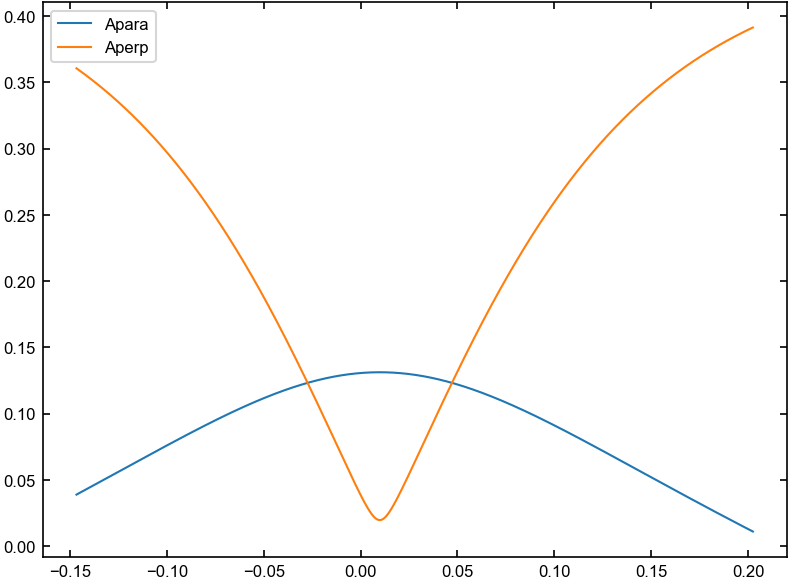

In [14]:
# Define physical quantization axes
A_paras  = []
A_perps = []

ay = -0.57 * np.pi / 180
ax = -0.7 * np.pi / 180

thetas =  1.6 /360*2*np.pi + np.linspace(-10 /360*2*np.pi, 10 /360*2*np.pi,1000)
phi_0 = 0.146 /360*2*np.pi
psi_0 = 0.368 /360*2*np.pi

b0 = 436.917
for theta in thetas :
    
    bx = b0 * (np.sin(theta) * np.sin(phi_0) - np.cos(theta) * np.sin(psi_0) * np.cos(phi_0))
    by = b0 * (np.sin(theta) * np.cos(phi_0) + np.cos(theta) * np.sin(psi_0) * np.sin(phi_0))
    bz = b0 * np.cos(theta) * np.cos(psi_0)


    B_field = (bx, by, bz)
    rotated_b_field = rotmat_yz(ay) @ rotmat_xz(ax) @ B_field

    n_e = _electron_axis(rotated_b_field, g_Er)              # electron axis || g^T B
    n_n = np.asarray(rotated_b_field, float)
    Tdd = get_hyperfine_tensor(g_Er, mu_Nb, W_pos[9, 1:])
    R_left, R_right = get_rotations(n_e, n_n)
    A_p = R_left @ Tdd @ R_right.T   # transpose on the nuclear rotationA_par = R_left @ Tdd @ R_right
    A_par = A_p[2,2]
    A_per = np.sqrt(A_p[2,0]**2+A_p[0,2]**2)
    A_paras.append(A_par)
    A_perps.append(A_per)
    
plt.plot(thetas,A_paras, label = 'Apara')
plt.plot(thetas,A_perps, label = 'Aperp')
plt.legend()
plt.show()






In [46]:
# Define physical quantization axes
n_e = _electron_axis(rotated_b_field, g_Er)              # electron axis || g^T B
n_n = np.asarray(rotated_b_field, float)
Tdd = get_hyperfine_tensor(g_Er, mu_Nb, W_pos[9, 1:])
R_left, R_right = get_rotations(n_e, n_n)
A_par = R_left @ Tdd @ R_right
print(A_par)



[[-0.00074668  0.00001446 -0.00144893]
 [-0.00000004 -0.00073296 -0.00000729]
 [ 0.00086375 -0.00130012  0.13068721]]


In [142]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange  # optional, just for progress bars

# --- Parameters ---
n_angles = 51
angle_range_deg = 5
angles = np.linspace(-angle_range_deg, angle_range_deg, n_angles)
y_angles = np.array([-0.57, 0.57]) / 180 * np.pi
angles_rad = np.deg2rad(angles)
B0 = 0.444
b_field = np.array([0, 0, B0])

# Make the full 2D sweep grid (each row is one (x,y) angle pair)
B = np.array([[ax, ay] for ay in y_angles for ax in angles_rad])

A_para_eff_list = []
A_para_exact_list = []
A_perp_exact_list = []

# --- Loop over W ions ---
fig = plt.figure(figsize=(12*2, 12*5))  # adjust size if you want
for i_w_pos in range(0, 11):
    w_pos = W_pos[i_w_pos, 1:]

    A_para_all_exact = np.empty(B.shape[0])
    A_perp_all_exact = np.empty(B.shape[0])

    # --- Vectorized-ish sweep (single loop over flattened grid) ---
    for j in trange(B.shape[0], desc=f"W ion {i_w_pos}"):
        ax, ay = B[j]
        rotated_b_field = rotmat_yz(ay) @ rotmat_xz(ax) @ b_field

        A_par, A_perp = get_hyperfine_constants(g_Er, mu_Nb, rotated_b_field, w_pos)

        A_para_all_exact[j] = A_par * 1e3    # in kHz
        A_perp_all_exact[j] = A_perp * 1e3    # in kHz
    
    A_para_exact_list.append(A_para_all_exact)
    A_perp_exact_list.append(A_perp_all_exact)



W ion 10: 100%|██████████| 102/102 [00:00<00:00, 2256.10it/s]


<Figure size 3600x9000 with 0 Axes>

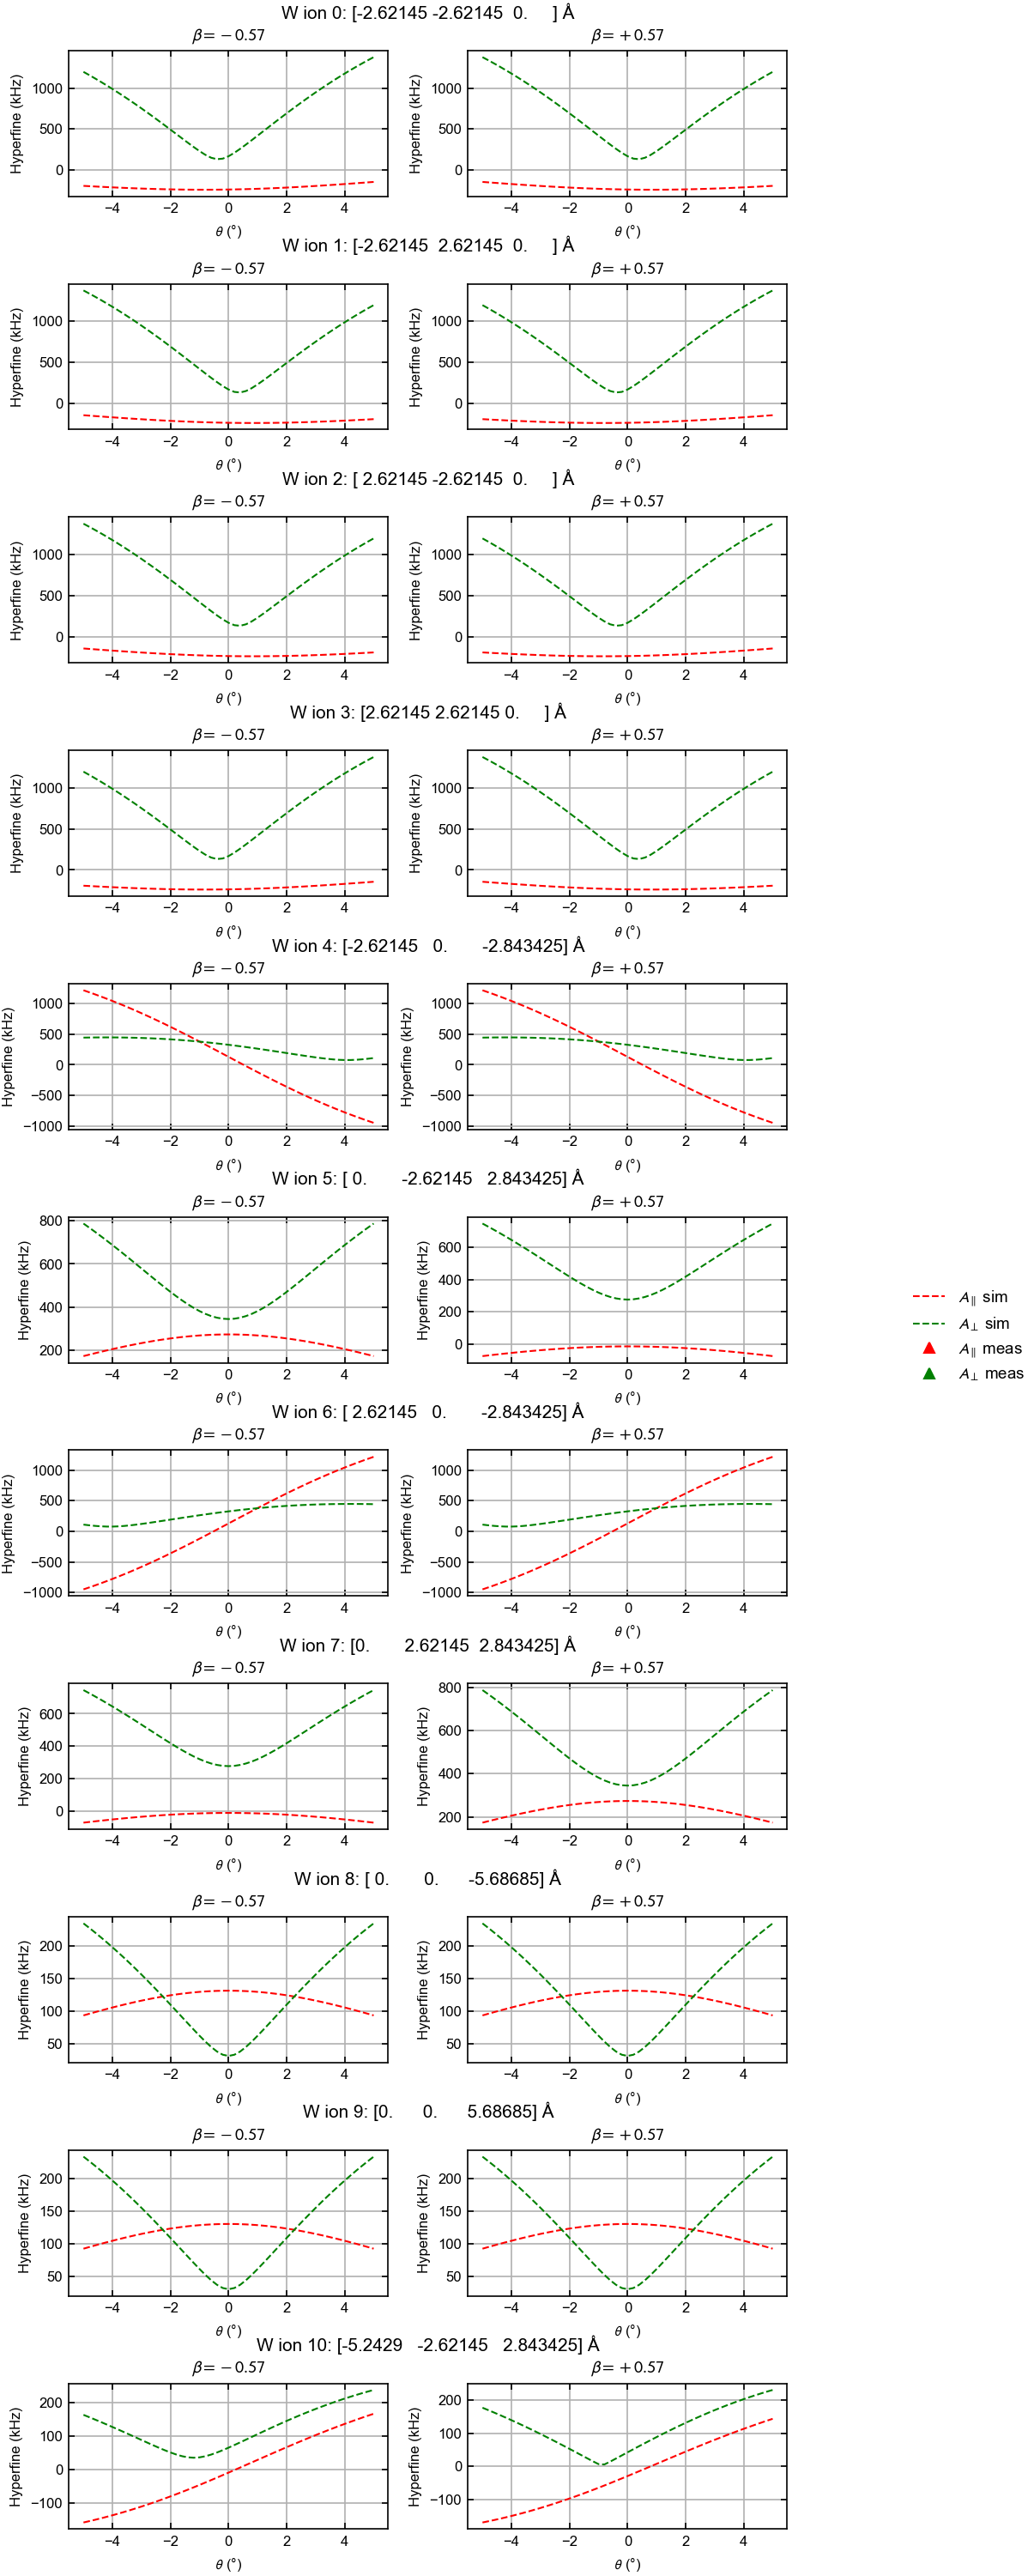

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# --- Figure + GridSpec ---
n_rows = 11
n_cols = 2

fig = plt.figure(figsize=(3*2.4, 5*5))  # a bit wider for legend
gs = fig.add_gridspec(
    n_rows, n_cols,
    hspace=0.6,
    wspace=0.25
)

# --------------------------------------------------
# Define legend handles ONCE
# --------------------------------------------------
legend_handles = [
    plt.Line2D([], [], linestyle="--", color="red",  label=r"$A_\parallel$ sim"),
    plt.Line2D([], [], linestyle="--", color="green", label=r"$A_\perp$ sim"),
    plt.Line2D([], [], marker="^", linestyle="None", color="red",  markersize=6,
               label=r"$A_\parallel$ meas"),
    plt.Line2D([], [], marker="^", linestyle="None", color="green", markersize=6,
               label=r"$A_\perp$ meas"),
]

# --- Loop over W ions ---
for i_w_pos in range(0, 11):

    w_pos = W_pos[i_w_pos, 1:]

    A_para_all_exact = A_para_exact_list[i_w_pos].reshape(2, n_angles)
    A_perp_all_exact = A_perp_exact_list[i_w_pos].reshape(2, n_angles)

    omega_I = -np.linalg.norm(b_field) * gamma_W_ref * 1e-3  # [kHz]

    # ==========================================================
    # Row title
    # ==========================================================
    ax_title = fig.add_subplot(gs[i_w_pos, :])
    ax_title.axis("off")
    ax_title.set_title(
        f"W ion {i_w_pos}: {w_pos*1e10} Å",
        fontsize=10,
        pad=18
    )

    # ==========================================================
    # --- Slice at θ_x = 0 ---
    # ==========================================================
    ax2 = fig.add_subplot(gs[i_w_pos, 0])

    ax2.plot(angles, A_para_all_exact[0, :], "--", color="red")
    ax2.plot(angles, A_perp_all_exact[0, :], "--", color="green")


    ax2.set_xlabel(r"$\theta$ (°)")
    ax2.set_ylabel("Hyperfine (kHz)")
    ax2.set_title(r"$\beta = -0.57$")
    ax2.grid(True)

    # ==========================================================
    # --- Slice at θ_y = 0 ---
    # ==========================================================
    ax3 = fig.add_subplot(gs[i_w_pos, 1])

    ax3.plot(angles, A_para_all_exact[1, :], "--", color="red")
    ax3.plot(angles, A_perp_all_exact[1, :], "--", color="green")


    ax3.set_xlabel(r"$\theta$ (°)")
    ax3.set_ylabel("Hyperfine (kHz)")
    ax3.set_title(r"$\beta = +0.57$")
    ax3.grid(True)

# --------------------------------------------------
# Global legend on the right
# --------------------------------------------------
fig.legend(
    handles=legend_handles,
    loc="upper left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=9
)

plt.show()


# Leon: if you want to get the A tensor in the field basis you need to rotate the tensor like the following

In [ ]:
A_crystal = get_hyperfine_tensor(g_Er, mu_Nb, W_pos[9, 1:])*1e3

In [ ]:
y_angle = -0.57 / 180 * np.pi
x_angle = -0.6 / 180 * np.pi
R = rotmat_yz(y_angle) @ rotmat_xz(x_angle)
R_field = R.T
A_field = R_field @ A_crystal @ R_field.T
A_field

array([[-441.66244757,   -0.05970534,   -6.00098845],
       [  -0.05970534, -441.66856909,    5.70123131],
       [  -6.00098845,    5.70123131,  131.30594568]])

# 2 nuclei

In [ ]:
# for 2-nuclear spin system
def get_2nuclear_zeeman_hamiltonian(mu_I1, mu_I2, B_field, Jvec, Ivec) -> Qobj: # [MHz]
    nJ, nI  = Jvec[0].dims[0][0], Ivec[0].dims[0][0]
    h_zeeman_nuclear_1  = tensor(get_nuclear_zeeman_hamiltonian(mu_I1, B_field, Ivec), qeye(nJ)) 
    h_zeeman_nuclear_2  = tensor(qeye(nJ),  get_nuclear_zeeman_hamiltonian(mu_I2, B_field, Ivec)) 
    return h_zeeman_nuclear_1 + h_zeeman_nuclear_2

def get_electron_2nuclear_zeeman_hamiltonian(g_elec, mu_I1, mu_I2, B_field, Jvec, Ivec) -> Qobj: # [MHz]
    nJ, nI  = Jvec[0].dims[0][0], Ivec[0].dims[0][0]
    h_zeeman_electron = tensor(get_electron_zeeman_hamiltonian(g_elec, B_field, Jvec), qeye(nI), qeye(nI))
    h_zeeman_nuclear_1  = tensor(qeye(nJ), get_nuclear_zeeman_hamiltonian(mu_I1, B_field, Ivec), qeye(nI)) 
    h_zeeman_nuclear_2  = tensor(qeye(nJ), qeye(nI),  get_nuclear_zeeman_hamiltonian(mu_I2, B_field, Ivec)) 
    return h_zeeman_electron + h_zeeman_nuclear_1 + h_zeeman_nuclear_2

def get_nuclera_dipolar_tensor(mu_I1, mu_I2, xyz):
    """
    Dipole-dipole tensor for nuclear–nuclear coupling.

    :param mu_I1: magnetic moment of nucleus 1
    :param mu_I2: magnetic moment of nucleus 2
    :param xyz: relative position vector r = r1 - r2 (meters)
    :returns: dipolar coupling tensor [MHz]
    """
    x, y, z = xyz
    r = np.linalg.norm(xyz)

    Tdd = np.zeros((3, 3))

    prefactor = (
        mu_0 / (4 * np.pi)
        * mu_I1 * mu_I2
        * r**-5
        * 1e-6 / h   # → MHz
    )

    # diagonal
    Tdd[0, 0] = r**2 - 3 * x**2
    Tdd[1, 1] = r**2 - 3 * y**2
    Tdd[2, 2] = r**2 - 3 * z**2

    # off-diagonal
    Tdd[0, 1] = Tdd[1, 0] = -3 * x * y
    Tdd[0, 2] = Tdd[2, 0] = -3 * x * z
    Tdd[1, 2] = Tdd[2, 1] = -3 * y * z

    Tdd *= prefactor

    # keep same sign convention as your hyperfine tensor
    return Tdd

def get_nuclear_dipolar_hamiltonian(mu_I1, mu_I2, xyz, I1vec, I2vec) -> Qobj:
    """
    Nuclear–nuclear dipolar Hamiltonian.

    :param mu_I1: magnetic moment of nucleus 1
    :param mu_I2: magnetic moment of nucleus 2
    :param xyz: relative position vector r1 - r2
    :param I1vec: (Ix1, Iy1, Iz1)
    :param I2vec: (Ix2, Iy2, Iz2)
    :returns: dipolar Hamiltonian [MHz]
    """
    Ix1, Iy1, Iz1 = I1vec
    Ix2, Iy2, Iz2 = I2vec

    Tdd = get_nuclear_dipolar_tensor(mu_I1, mu_I2, xyz)

    return (
        Tdd[0,0] * tensor(Ix1, Ix2)
      + Tdd[1,1] * tensor(Iy1, Iy2)
      + Tdd[2,2] * tensor(Iz1, Iz2)
      + Tdd[0,1] * tensor(Ix1, Iy2)
      + Tdd[1,0] * tensor(Iy1, Ix2)
      + Tdd[0,2] * tensor(Ix1, Iz2)
      + Tdd[2,0] * tensor(Iz1, Ix2)
      + Tdd[1,2] * tensor(Iy1, Iz2)
      + Tdd[2,1] * tensor(Iz1, Iy2)
    )


def get_hamiltonian_2_nuclear_spin(mu_I1, mu_I2, xyz, B_field) -> Qobj:

    J, I = 1/2, 1/2
    nJ = int(2*J + 1)
    nI = int(2*I + 1)
    Jvec = Jx, Jy, Jz = spin_J_set(J)
    Ivec = Ix, Iy, Iz = spin_J_set(I)
    
    h_Zeeman = get_2nuclear_zeeman_hamiltonian(mu_I1, mu_I2, B_field, Ivec, Ivec)
    h_dipole = get_nuclear_dipolar_hamiltonian(mu_I1, mu_I2, xyz, Ivec, Ivec) 
    return h_Zeeman + h_dipole

# 1 electron + 2 nuclei

In [79]:
# ============================================================
# FULL 1 electron + 2 nuclear Hamiltonian
# ============================================================

def get_hamiltonian_1_electron_2_nuclear_spin(
    g_elec,
    mu_I1,
    mu_I2,
    r1,      # electron → nucleus 1
    r2,      # electron → nucleus 2
    B_field
) -> Qobj:

    # spins
    J = 1/2
    I = 1/2

    Jvec = Jx, Jy, Jz = spin_J_set(J)
    Ivec = Ix, Iy, Iz = spin_J_set(I)

    nJ = int(2*J + 1)
    nI = int(2*I + 1)

    IdJ = qeye(nJ)
    IdI = qeye(nI)

    # --------------------------------------------------
    # Electron Zeeman: J ⊗ 1 ⊗ 1
    # --------------------------------------------------
    H_eZ = tensor(
        get_electron_zeeman_hamiltonian(g_elec, B_field, Jvec),
        IdI,
        IdI
    )

    # --------------------------------------------------
    # Nuclear Zeeman: 1 ⊗ I ⊗ 1  and  1 ⊗ 1 ⊗ I
    # --------------------------------------------------
    H_nZ_1 = tensor(
        IdJ,
        get_nuclear_zeeman_hamiltonian(mu_I1, B_field, Ivec),
        IdI
    )

    H_nZ_2 = tensor(
        IdJ,
        IdI,
        get_nuclear_zeeman_hamiltonian(mu_I2, B_field, Ivec)
    )

    # --------------------------------------------------
    # Electron–nuclear hyperfine
    # --------------------------------------------------
    T1 = get_hyperfine_tensor(g_elec, mu_I1, r1)
    T2 = get_hyperfine_tensor(g_elec, mu_I2, r2)

    H_hf_1 = (
        T1[0,0]*tensor(Jx, Ix, IdI) + T1[1,1]*tensor(Jy, Iy, IdI) + T1[2,2]*tensor(Jz, Iz, IdI)
      + T1[0,1]*tensor(Jx, Iy, IdI) + T1[1,0]*tensor(Jy, Ix, IdI)
      + T1[0,2]*tensor(Jx, Iz, IdI) + T1[2,0]*tensor(Jz, Ix, IdI)
      + T1[1,2]*tensor(Jy, Iz, IdI) + T1[2,1]*tensor(Jz, Iy, IdI)
    )

    H_hf_2 = (
        T2[0,0]*tensor(Jx, IdI, Ix) + T2[1,1]*tensor(Jy, IdI, Iy) + T2[2,2]*tensor(Jz, IdI, Iz)
      + T2[0,1]*tensor(Jx, IdI, Iy) + T2[1,0]*tensor(Jy, IdI, Ix)
      + T2[0,2]*tensor(Jx, IdI, Iz) + T2[2,0]*tensor(Jz, IdI, Ix)
      + T2[1,2]*tensor(Jy, IdI, Iz) + T2[2,1]*tensor(Jz, IdI, Iy)
    )

    # --------------------------------------------------
    # Nuclear–nuclear dipolar: 1 ⊗ (I ⊗ I)
    # --------------------------------------------------
    H_nn = tensor(
        IdJ,
        get_nuclear_dipolar_hamiltonian(mu_I1, mu_I2, r1 - r2, Ivec, Ivec)
    )

    return H_eZ + H_nZ_1 + H_nZ_2 + H_hf_1 + H_hf_2 + H_nn

In [ ]:
B_field = (0, 0.0, 0.446)
hamiltonian = get_hamiltonian_2_nuclear_spin(mu_Nb, mu_W, W_pos[9, 1:] - W_pos[6, 1:], B_field)
hamiltonian.eigenstates()

(array([-63.85787024, -45.3272915 ,  45.327293  ,  63.85786874]),
 array([Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[ 1.        ]
         [-0.00000002]
         [-0.        ]
         [ 0.        ]]                                                             ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[ 0.00000002]
         [ 1.        ]
         [-0.00000001]
         [ 0.        ]]                                                             ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[0.        ]
         [0.00000001]
         [1.        ]
         [0.00000002]]                                                              ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[-0.        ]
         [-0.        ]
      

In [60]:
def get_nuclear_nuclear_coupling(hamiltonian: Qobj):
    energies, _ = hamiltonian.eigenstates()
    # We are only interseted in the ground state of the Er3+ doublet + nuclear spin states
    return ((energies[3] + energies[0]) - (energies[2] + energies[1]))/2*1e6  # in Hz

In [86]:
hamiltonian = get_hamiltonian_2_nuclear_spin(mu_Nb, mu_W, W_pos[9, 1:] - W_pos[6, 1:], B_field)
get_nuclear_nuclear_coupling(hamiltonian)

-1.5049839099390283

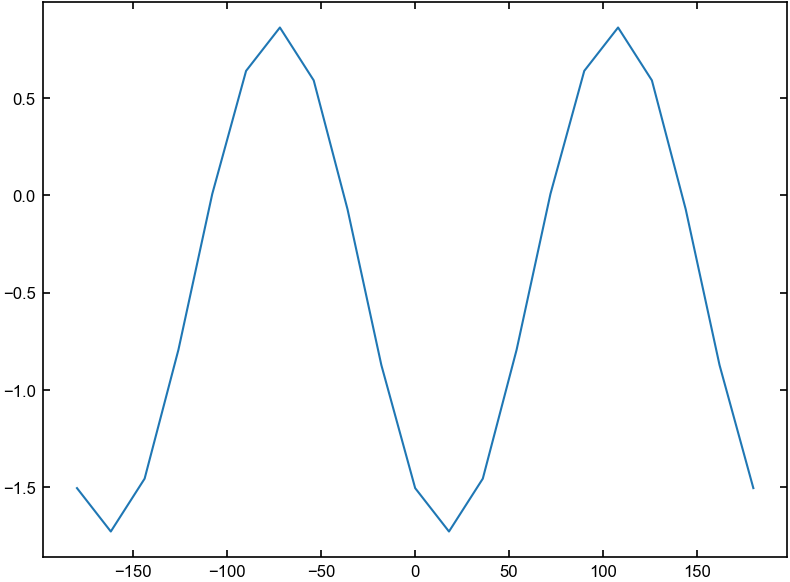

In [69]:
coupling_list = []
y_angle = -0.57 / 180 * np.pi
x_angle = -0.3 / 180 * np.pi
angle_list = np.linspace(-180, 180, 21) / 180 * np.pi
for x_angle in angle_list:
    B = np.array([0.0, 0.0, 447.0])  # mT
    rotated_b_field = rotmat_yz(y_angle) @ rotmat_xz(x_angle) @ B
    hamiltonian = get_hamiltonian_2_nuclear_spin(mu_Nb, mu_W, W_pos[9, 1:] - W_pos[6, 1:], rotated_b_field)
    coupling = get_nuclear_nuclear_coupling(hamiltonian)
    coupling_list.append((coupling))
plt.plot(angle_list*180/np.pi, coupling_list)

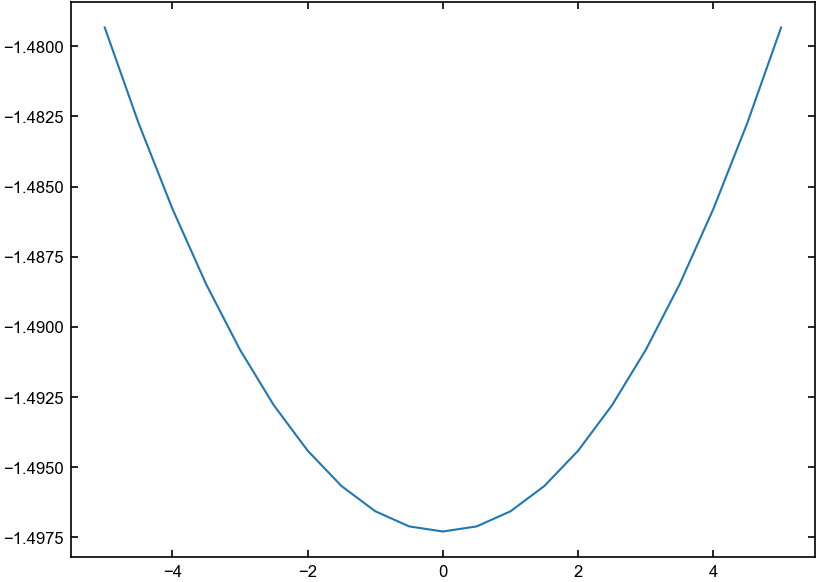

In [68]:
coupling_list = []
y_angle = -0.57 / 180 * np.pi
x_angle = -0.3 / 180 * np.pi
angle_list = np.linspace(-5, 5, 21) / 180 * np.pi
for y_angle in angle_list:
    B = np.array([0.0, 0.0, 447.0])  # mT
    rotated_b_field = rotmat_yz(y_angle) @ rotmat_xz(x_angle) @ B
    hamiltonian = get_hamiltonian_2_nuclear_spin(mu_Nb, mu_W, W_pos[9, 1:] - W_pos[6, 1:], rotated_b_field)
    coupling = get_nuclear_nuclear_coupling(hamiltonian)
    coupling_list.append((coupling))
plt.plot(angle_list*180/np.pi, coupling_list)

In [ ]:
y_angle = -0.57 / 180 * np.pi
x_angle = -0.3 / 180 * np.pi
B = np.array([0.0, 0.0, 441.0])  # mT
rotated_b_field = rotmat_yz(y_angle) @ rotmat_xz(x_angle) @ B

hamiltonian = get_hamiltonian_1_electron_2_nuclear_spin(
    g_Er,
    mu_Nb,
    mu_W,
    W_pos[9, 1:],      # electron → nucleus 1
    W_pos[8, 1:],      # electron → nucleus 2
    rotated_b_field
)
get_nuclear_nuclear_coupling(hamiltonian)

-0.7925555109977722